## Importing Statements

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile as zip_
from glob import glob
from music21 import *
import pickle

%matplotlib inline

## Extracting the Data

In [2]:
# Path of zip_data  and Path where data is to be extracted
working_dir = '../datasets'
zip_path = os.path.join(working_dir, 'zip_file/schubert.zip')
extraction_path = os.path.join(working_dir, 'midi_data')

# Unzipping the Data
zip = zip_.ZipFile(zip_path)
zip.extractall(extraction_path)

## Loading the Data

In [3]:
# List of extracted files
os.listdir(extraction_path)

['schubert_D850_4.mid',
 'schubert_D850_1.mid',
 'schuim-4.mid',
 'schumm-5.mid',
 'schumm-2.mid',
 'schumm-4.mid',
 'schub_d960_1.mid',
 'schubert_D935_2.mid',
 'schub_d760_1.mid',
 'schuim-2.mid',
 'schu_143_3.mid',
 'schubert_D850_3.mid',
 'schub_d960_3.mid',
 'schuim-3.mid',
 'schubert_D850_2.mid',
 'schuim-1.mid',
 'schub_d760_3.mid',
 'schu_143_2.mid',
 'schub_d760_2.mid',
 'schumm-1.mid',
 'schub_d760_4.mid',
 'schubert_D935_4.mid',
 'schu_143_1.mid',
 'schumm-6.mid',
 'schumm-3.mid',
 'schubert_D935_1.mid',
 'schubert_D935_3.mid',
 'schub_d960_2.mid',
 'schub_d960_4.mid']

In [4]:
# Using Music21 Library for reading the midi files
# Reading a single File.

notes = []
notes_to_parse = None

file = os.path.join(extraction_path, 'schuim-4.mid')

# Parsing a Midi file
midi = converter.parse(file)   ############################      type (<class 'music21.stream.Score'>)

# Grouping based on different instruments
s2 = instrument.partitionByInstrument(midi)   #################      type (<class 'music21.stream.Score'>)

# Iterating over all Parts
for part in s2.parts:
    if "Piano" in str(part):
        # Getting all the elements to parse.
        notes_to_parse = part.recurse()      ##########    type(<class 'music21.stream.iterator.StreamIterator'>)
        
        # Finding whether the particular element is note or chord
        for element in notes_to_parse:
            
            # Getting Notes
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                
            # Getting Chord    
            if isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                
notes = np.array(notes)
len(notes)

3783

In [5]:
# reading all files
def read_files(file):
    notes = []
    notes_to_parse = None

    # Parsing a Midi file
    midi = converter.parse(file)   ############################      type (<class 'music21.stream.Score'>)

    # Grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)   #################      type (<class 'music21.stream.Score'>)

    # Iterating over all Parts
    for part in s2.parts:
        if "Piano" in str(part):
            # Getting all the elements to parse.
            notes_to_parse = part.recurse()      ##########    type(<class 'music21.stream.iterator.StreamIterator'>)
        
            # Finding whether the particular element is note or chord
            for element in notes_to_parse:
            
                # Getting Notes
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                # Getting Chord    
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
                
    return np.array(notes)    

In [6]:
# Loading all files and getting all their notes
midi_audio_files = glob(extraction_path + '/*.mid')
notes_ar = np.array([read_files(i) for i in midi_audio_files])

In [7]:
notes_ar.shape

(29,)

In [8]:
notes_ar[0].shape

(4243,)

In [9]:
notes = [element for notes in notes_ar for element in notes]

In [10]:
notes = np.array(notes)
notes.shape

(66957,)

In [11]:
# No of Unique notes
unique_notes = list(set(notes))
len(unique_notes)

304

In [12]:
# Counting all notes
frequency = dict.fromkeys(unique_notes, 0)
for i in notes:
    frequency[i] += 1

In [13]:
import seaborn as sns
freq_values = list(frequency.values())

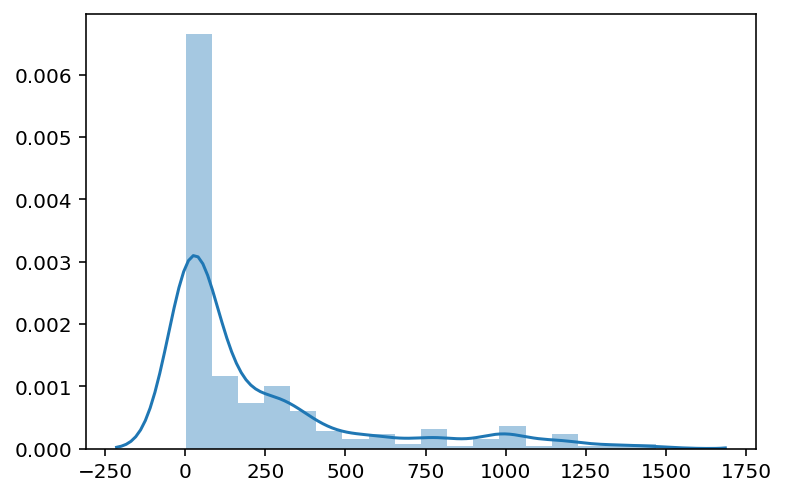

In [14]:
sns.distplot(freq_values, kde=True)

(array([187.,  41.,  26.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4790e+02, 2.9480e+02, 4.4170e+02, 5.8860e+02,
        7.3550e+02, 8.8240e+02, 1.0293e+03, 1.1762e+03, 1.3231e+03,
        1.4700e+03]),
 <a list of 10 Patch objects>)

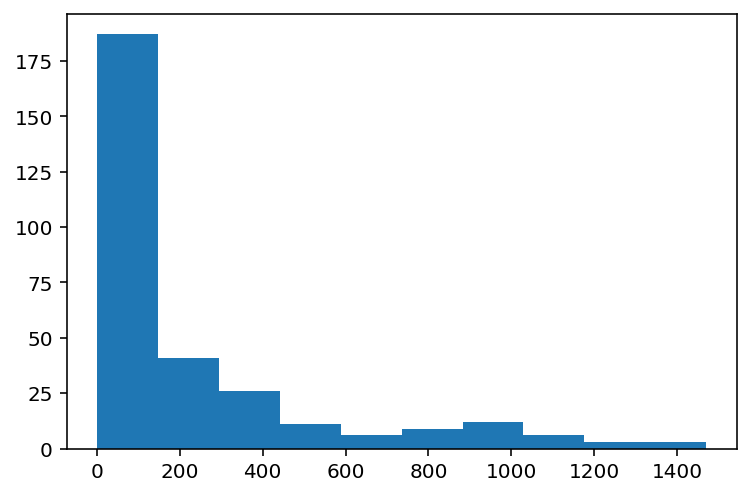

In [15]:
plt.hist(freq_values)

### Cleaning the Data

In [16]:
# Removing Those notes which are having frequency less than 30.
final_notes = [note for note, count in frequency.items() if count >=  30]

In [17]:
# Total number of unique notes which have frequency greater than 30
len(final_notes)

189

In [18]:
# Out of 304 unique notes, there are only 189 notes which have frequency greater than 30

In [19]:
new_music = []
for notes in notes_ar:
    temp = []
    for note in notes:
        if note in final_notes:
            temp.append(note)
    new_music.append(temp)
    
# Changing the new music array to numpy array
new_music = np.array(new_music)

### Preparation of the Data

In [20]:
# Preparation of the Data
timestep = 32

X = []
y = []

for notes in new_music:
    for i in range(32, len(notes)):
        input_ = notes[i-32: i]
        output_ = notes[i]
        
        X.append(input_)
        y.append(output_)
        
X = np.array(X)
y = np.array(y)

In [21]:
X.shape, y.shape

((65268, 32), (65268,))

In [32]:
# Enumeration of the notes in the input data
unique_X_notes = list(set(X.reshape(-1)))
X_notes_index = dict((note, i) for i, note in enumerate(unique_X_notes))

# Enumeration of the notes in the output data
unique_y_notes = list(set(y.reshape(-1)))
y_notes_index = dict((note, i) for i, note in enumerate(unique_y_notes))

In [35]:
# Preparing integer sequence of the input data
X_seq = []

for i in X:
    temp = []
    for j in i:
        temp.append(X_notes_index[j])
    X_seq.append(temp)
    
X_seq = np.array(X_seq)


# Preparing integer sequence of output data
y_seq = []
for i in y:
    y_seq.append(y_notes_index[i])

y_seq = np.array(y_seq)

In [36]:
# Printing shape of the Integer Sequenced Data
X_seq.shape, y_seq.shape

((65268, 32), (65268,))

In [43]:
# Saving the data for further works
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'input_notes.pkl'),'wb') as f:
    pickle.dump(X, f)
    
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'output_notes.pkl'),'wb') as f:
    pickle.dump(y, f)

In [44]:
# Saving the data for further works
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'input.pkl'),'wb') as f:
    pickle.dump(X_seq, f)
    
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'output.pkl'),'wb') as f:
    pickle.dump(y_seq, f)

In [45]:
# Loading the Data
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'input.pkl'),'rb') as f:
    X_seq = pickle.load(f)

with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'output.pkl'),'rb') as f:
    y_seq = pickle.load(f)

In [46]:
# Printing the shape of the Data
X.shape, y.shape

((65268, 32), (65268,))